_Neural Data Analysis_

Lecturer: Prof. Dr. Philipp Berens

Tutors: Sarah Strauss, Ziwei Huang

Summer term 2021

Names: FILL IN YOUR NAMES HERE

# Coding Lab 10 

Introduction into the analysis of neural morphologies (10 pts + bonus 3 pts)

## Introduction

The anatomical shape of a neuron — its morphology — has fascinated scientists ever since the pioneering work of Cajal (Ramon y Cajal, 1911). A neuron's dendritic and axonal processes naturally decide what other neurons it can connect to, hence, its shape plays an important role for its function in the circuit. In particular, different functional types of neurons have fundamentally different morphologies.

This notebook will introduce you to the analysis of neural morphologies using the dendrites of over $500$ retinal ganglion cells. The aim is to teach you two different ways of representing morphologies and give you an impression of their repsective strengths and weaknesses.

### Data set

The data set contains morphological reconstructions of $599$ retinal ganglion cell dendrites with cell type label and projection target to either the parabigeminal (Pbg) or the pulvinar nucleus (LP)([Reinhard et al. (2019)](https://elifesciences.org/articles/50697)). 
Here we only keep cells that map to clusters with more than six cells per cluster which leads to $550$ remaining reconstructions. 

Download the data file `nda_ex_10_data.zip` from ILIAS and unzip it in a subfolder `../data/`


### Software

We will use MorphoPy (Laturnus, et al., 2020; https://github.com/berenslab/MorphoPy) for this exercise. You can install it via `pip`:

```
pip install morphopy
```

Most of the computations and even some plottings will be handled by MorphoPy. You can learn more about MorphoPy's APIs in this [tutorial](https://nbviewer.jupyter.org/github/berenslab/MorphoPy/blob/master/notebooks/MORPHOPY%20Tutorial.ipynb). 

In [3]:
import pandas as pd
import numpy as np
import os

from morphopy.computation import file_manager
from morphopy.neurontree.plotting import show_threeview
from morphopy.neurontree import NeuronTree as nt

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_context('notebook')

# Inspect the raw data

#### File format

Morphological reconstructions are typically stored in the SWC file format, a simple text file that holds node information in each row and connects nodes through the `parent` node id. A parent id of -1 indicates no parent, so the starting point of the tree graph, also called the root. 
The `type` label indicates the node type (1: somatic , 2: axonal, 3: dendritic (basal), 4: dendritic (apical), 5+: custom).
The code snippet below loads in one swc file and prints its head. 

You can find a more detailed specification of SWC and SWC+ [here](http://www.neuronland.org/NLMorphologyConverter/MorphologyFormats/SWC/Spec.html) and [here](https://neuroinformatics.nl/swcPlus/).



In [4]:
def load_swc(filepath):
    """ 
    Loads in the swc located at filepath as a pandas dataframe.
    """
    swc = pd.read_csv(filepath, delim_whitespace=True, comment='#',
                      names=['n', 'type', 'x', 'y', 'z', 'radius', 'parent'], index_col=False)
    return swc

colors = sns.color_palette('rainbow_r', n_colors=14)

In [6]:
PATH = '../data/nda_ex_10_data/'
data_path = PATH + 'neurons/soma-centered/'
filename = '0006_00535_4L_C02_01.swc'
filepath = data_path + filename

swc = load_swc(filepath)
swc.head()

,n,type,x,y,z,radius,parent
0,1,1,0.0,0.0,47.0,1.0,-1
1,2,3,-3.0,0.0,47.0,1.0,1
2,3,3,17.0,-8.0,51.0,1.0,1
3,4,3,24.0,-31.0,38.0,1.0,3
4,5,3,2.0,14.0,42.0,1.0,1


The labels `x`, `y`, and `z` hold a node's 3D coordinate in tracing space (here in microns). For reasons of simplicity we will work with reconstructions that are soma centered in XY.

The assigned cell type labels are stored in the file `rgc_labels.csv` and indexed by their `Cell_nr`. In this file you find three different cluster assignments: `clusterA` is the assignment of the authors (clus1 -- clus14), `clusterB` is the respective cluster identifier of the [Eyewire museum](http://museum.eyewire.org) (also see [Bae et al. 2018](https://www.sciencedirect.com/science/article/pii/S0092867418305725)), and `clusterC` are molecular or functional label names when available. 
We have formatted the cluster assignments of the authors (`clusterA`) into integer values and stored them in the column `cluster`, which we will use in the following.

In [7]:
labels = pd.read_csv(PATH + "rgc_labels.csv", index_col=0)

cluster_label, cluster_counts = np.unique(labels['cluster'], return_counts=True)
labels.head()

,Cell_nr,projection_site,clusterA,clusterB,clusterC,cluster
1,2,LP,clus6,4ow,tOFFα,6
2,3,LP,clus2,2an,F-mini-OFF,2
3,4,LP,clus1,1wt,sOFFα,1
4,6,LP,clus7,5to,NaN,7
5,7,LP,clus10,6sn,NaN,10


## Task 1: Plotting individual morphologies

Load data using `file_manager` and plot individual morphologie using `show_threeview` of from `MorphoPy`. It plots all three planar views on the reconstruction. 

Here, XY shows the planar view on top of the retina, and Z denotes the location within the inner plexiform layer (IPL).

*Grading: 2pts*

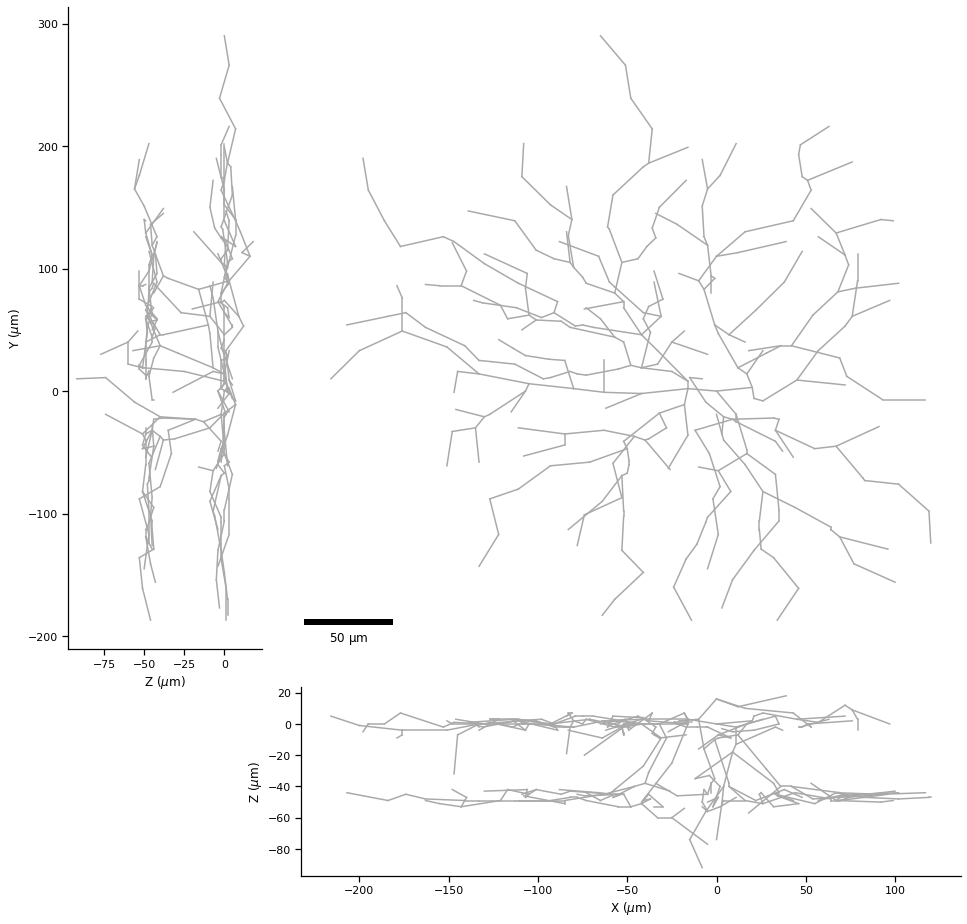

In [10]:
# get the list of file names
files = list(os.walk(data_path))[0][2] 
files.sort()

# load the morphology using file_manager (0.5pt)
ix = 19
filepath = data_path + files[ix]
morphology_data = file_manager.load_swc_file(filepath)

# plot all three planar views using show_threeview (0.5pt)
show_threeview(morphology_data)

SWC files are a compact way for storing neural morphologies but their graph structure makes them difficult to handle for current machine learning methods. We, therefore, need to convert our reconstructions into a reasonable vector-like representations. 

Here we will present two commonly chosen representations: Morphometric statistics and density maps


In [11]:
# load all reconstructions. Note: files are sorted by cell number (1pt)
def load_files(path):
    """ Returns an object array of NeuronTrees containing all reconstructions at `path`. 
    The reconstructions are sorted ascendingly by their filename."""
    neurons = []
    path, _, files = list(os.walk(path))[0]
    files.sort()
    # load all morphology using file_manager
    for f in files:
        N = file_manager.load_swc_file(path+f)
        neurons.append(N)
    return neurons

neurons = load_files(data_path)
print("Number of reconstructions: ", len(neurons))

Number of reconstructions:  550


## Task 2: Morphometric statistics

Morphometric statistics denote a set of hand-crafted single valued features such as `soma radius`, `number of tips` or `average branch angle`. For a more detailed explanation of morphometrics please refer to the [MorphoPy documentation](https://github.com/berenslab/MorphoPy#morphometric-statistics).

*Grading: 3pts*

First, you should compute this representation for each cell using the function `compute_morphometric_statistics` of the MorphoPy package which computes a predefined set of $28$ statistics. (1pt)



In [16]:
from morphopy.computation.feature_presentation import compute_morphometric_statistics

# 1. extraction of morphometric statistics on entire data set
all_neuron_statistics = [compute_morphometric_statistics(N) for N in neurons]

# 2. concatenate data into one table and set the Cell_nr as index
morphometric_statistics = pd.concat(all_neuron_statistics)
morphometric_statistics = morphometric_statistics.set_index(labels['Cell_nr'])

morphometric_statistics.head()

,branch_points,width,depth,height,tips,stems,total_length,avg_thickness,max_thickness,total_surface,...,median_intermediate_segment_pl,median_terminal_segment_pl,log_max_tortuosity,log_min_tortuosity,log_median_tortuosity,max_branch_angle,min_branch_angle,mean_branch_angle,max_degree,tree_asymmetry
Cell_nr,,,,,,,,,,,,,,,,,,,,,
2,66.0,412.0,596.0,54.0,69.0,3.0,6579.358659,1.0,1.0,41339.329656,...,33.479847,45.619642,0.253612,0.0,0.005766,124.974479,7.286952,50.402105,3.0,0.726199
3,18.0,307.0,266.0,68.0,23.0,1.0,1865.736494,1.0,1.0,11722.768129,...,34.501425,34.999147,0.285133,0.0,0.000564,110.367090,18.036960,57.088068,3.0,0.738502
4,54.0,505.0,353.0,72.0,61.0,6.0,4134.984734,1.0,1.0,25980.875324,...,20.211076,28.106939,0.312270,0.0,0.000000,131.508679,25.596621,59.646776,3.0,0.706943
6,36.0,345.0,438.0,49.0,39.0,4.0,3224.958032,1.0,1.0,20263.008923,...,21.708403,41.299541,0.251400,0.0,0.017747,130.034126,16.436535,54.683803,2.0,0.601296
7,31.0,413.0,386.0,58.0,40.0,7.0,3464.729453,1.0,1.0,21769.537191,...,24.839485,53.008633,0.217363,0.0,0.024678,104.036243,2.970445,55.498150,3.0,0.579942


Now visualize the data: Make a scatter plot for each morphometric statistics for each cluster. (1pt) 

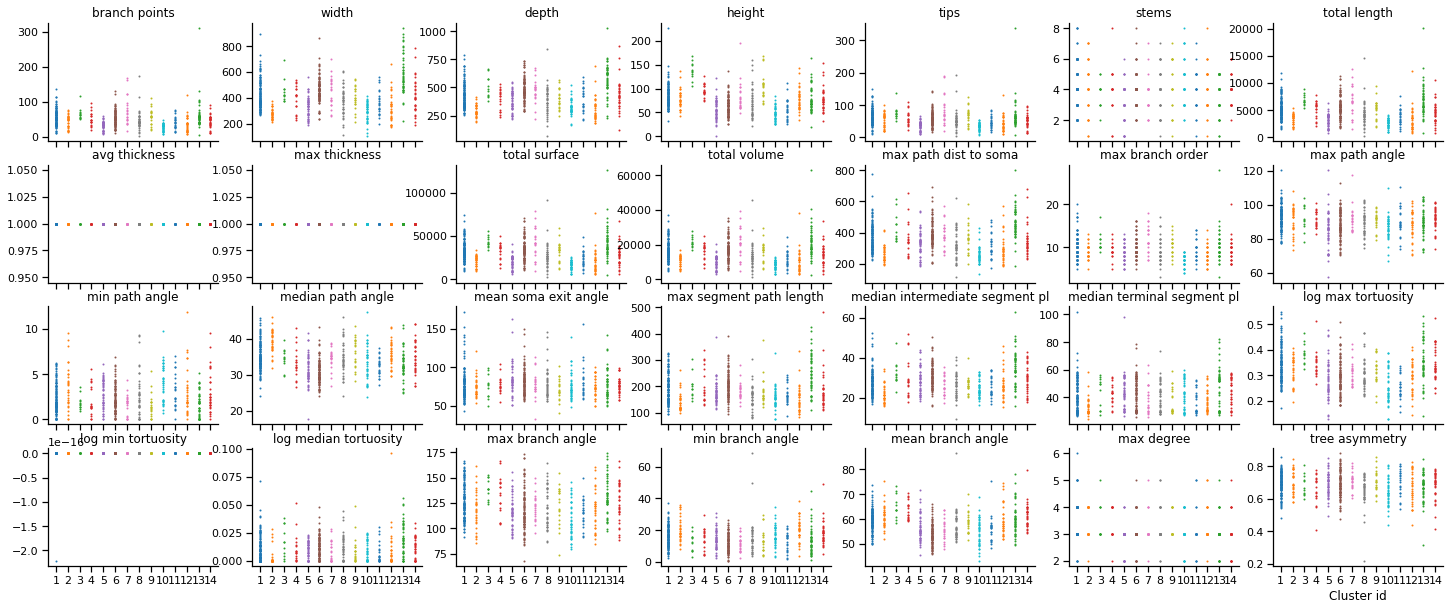

In [25]:
# visualize. Which are the most discriminative ones?

features = morphometric_statistics.columns.values

fig, axes = plt.subplots(4,7, figsize=(25,10), sharex = True)
axes = axes.flatten()

for k, feature in enumerate(features):
    for l in np.unique(labels['cluster']):
        label_index = (labels['cluster'] == l).values
        cluster_cells = morphometric_statistics[label_index]
        axes[k].scatter([l]*cluster_cells.shape[0], cluster_cells[feature], s=1)
        axes[k].set_title(feature.replace("_", " "))

axes[-1].set_xticks(range(1,15))
axes[-1].set_xlabel('Cluster id')
sns.despine()

**Q3.a:** Which statistics separate clusters well? Which can be removed? (tips: there are 5 uninformative features) (1pt) 

**Answer:** 

**Q3.b:** More generally, what do morphometric statistics capture well? What are their advantages, what might be their downsides? Briefly explain. (bonus: 0.5pt)

**Answer:** 

In [31]:
# For further analysis (task 4), we will remove uninformative features and z-score along each statistic
features_to_drop = ['stems', 'avg_thickness', 'max_thickness', 'log_min_tortuosity', 'max_degree'] 
morphometric_statistics = morphometric_statistics.drop(features_to_drop, axis=1)

# z-score morphometrics and remove nans and uninformative features
morphometric_data = (morphometric_statistics - morphometric_statistics.mean())/morphometric_statistics.std()
morphometric_data[morphometric_data.isna()] = 0
morphometric_data = morphometric_data.values

## Task 3: Density maps

Density maps project a neuron's 3D point cloud ($x$, $y$, $z$) onto a plane or an axis, and bin the projected point cloud into a fixed number of bins. Hereby, the binning controls how much global or local information is kept, which majorly affects the results.
While density maps ignore the connectivity between nodes and only assign value to neurite density, this representation can be powerful, when cell type and location in the brain area are highly correlated. 

**Exercise:** Compute the density maps of all neurons onto all cardinal planes and axes using the method `compute_density_maps`. You can manipulate the parameters for the density maps via the dictonary `config`. 
Make sure that you normalize the density maps globally and bin each direction into $20$ bins.
You are welcome to explore, how the different projections look like but we will only use the z-projection for further analysis.


Possible parameters to pass are:

- distance: (default=1, in microns) determines the resampling distance.
- bin_size: (default=20, in microns). If set the number of bins will be computed such that one bin 
spans `bin_size` microns. This is overwritten when `n_bins_x/y/z` is set!
- n_bins_x/y/z: (default=None) specifies the number of bins for each dimension. If set it will overwrite the 
`bin_size` flag.
- density: (default=True) bool to specify if a density or counts are returned.
- smooth: (default=True) bool to trigger Gaussian smoothing.
- sigma: (default=1) determines std of the Gaussian used for smoothing. The bigger the sigma the more smoothing occurs. If smooth is set to False this parameter is ignored. 
- r_min_x/y/z: (in microns) minimum range for binning of x, y, and z. This value will correspond to the 
minimal histogram edge. 
- r_max_x/y/z: (in microns) maximum range for binning for x, y, and z. This value will correspond to the 
maximal histogram edge. 

*Grading: 3pts*

In [71]:
# Find the minimal and maximal x, y,z - coordinates in the data set to normalize the density maps globally
# which corresponds to r_min_x/y/z and r_max_x/y/z (1pt)

all_coordinates = np.vstack([np.array([x[1]['pos'] for x in list(neuron._G.nodes(data=True))]) for neuron in neurons])

minimal_coordinates = np.min(all_coordinates, axis=0)
maximal_coordinates = np.max(all_coordinates, axis=0)

print('Minimal coordinates: ', minimal_coordinates)
print('Maximal coordinates: ', maximal_coordinates)

Minimal coordinates:  [-634. -549. -226.]
Maximal coordinates:  [514. 536. 159.]


In [76]:
from morphopy.computation.feature_presentation import compute_density_maps

# complete the config dict (1pt)
config_global = dict(distance=1, 
                     n_bins_x=20, 
                     n_bins_y=20, 
                     n_bins_z=20, 
               density=True,smooth=True, sigma=1, 
               r_max_x=maximal_coordinates[0], r_max_y=maximal_coordinates[1], r_max_z=maximal_coordinates[2], 
               r_min_x=minimal_coordinates[0], r_min_y=minimal_coordinates[1], r_min_z=minimal_coordinates[2])

density_maps= [compute_density_maps(n, config_params=config_global) for n in neurons] # this line might take a while

# extract the z density map
DM_Z = np.array([dm['z_proj']['data'] for dm in density_maps])

Text(0, 0.5, 'Bins')

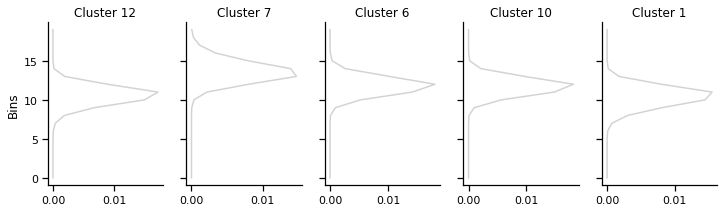

In [77]:
# plot z-density maps of 5 randomly chosen individual cells
random_index = np.random.choice(range(len(neurons)), size=5, replace=False)

fig, axes = plt.subplots(1,5,figsize=(12,3), sharey=True)
for k, ix in enumerate(random_index):
    axes[k].plot(DM_Z[ix,:],range(20), c='lightgrey')
    axes[k].set_title('Cluster %i'%labels.iloc[ix]['cluster'])
sns.despine()
axes[0].set_ylabel('Bins')

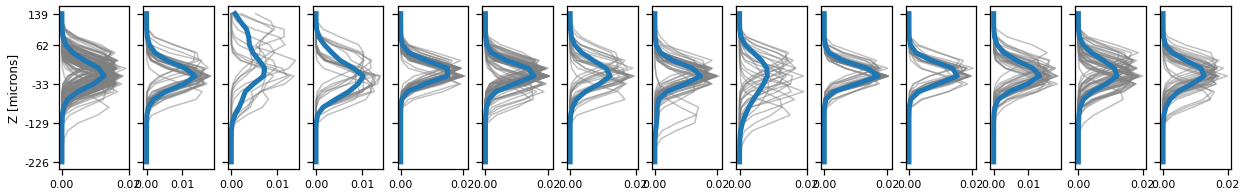

In [88]:
# plot the Z-density map sorted by class label, 
# and color-code the mean of each cluster (1pt)

fig, axes = plt.subplots(1, 14, figsize=(21,3), sharey=True)
axes = axes.flatten()

for i, cluster in enumerate(range(1, len(axes)+1)):
    cluster_data = DM_Z[labels['cluster'] == cluster]
    [axes[i].plot(cluster_data[k, :], range(20), color='gray', alpha=0.5) for k in range(cluster_data.shape[0])]
    axes[i].plot(np.mean(cluster_data, axis=0), range(20), linewidth=5)

axes[0].set_yticks([0,5,10,15,19])
axes[0].set_yticklabels(density_maps[0]['z_proj']['edges'][0][[0,5,10,15,19]].astype(int))
_ = axes[0].set_ylabel('Z [microns]')

## 2D embedding using t-SNE


Embed both data, the morphometric statistics and the density maps, in 2D using t-SNE and color each embedded point by its cluster assignment.

We use `openTSNE` for this part: `pip install opentsne`

*Grading: 2pts*

In [128]:
from openTSNE import TSNE
# from sklearn.manifold import TSNE

## fill in code here for the t-SNE fit
# tsne_morph_stats = TSNE().fit_transform(morphometric_data)
# tsne_density_maps = TSNE().fit_transform(DM_Z)

embedding_morph_stats = TSNE().fit(morphometric_data)
embedding_density_maps = TSNE().fit(DM_Z)

TypeError: __init__() got an unexpected keyword argument 'algorithm'

In [121]:
def plot_tsne(data, ax):
    for cluster in range(1, 16):
        label_index = (labels['cluster'] == cluster).values
        cluster_cells = data[label_index]
        ax.scatter(cluster_cells[:, 0], cluster_cells[:, 1], label=f'cluster {cluster}')

Text(0.5, 0.98, 't-SNE embedding')

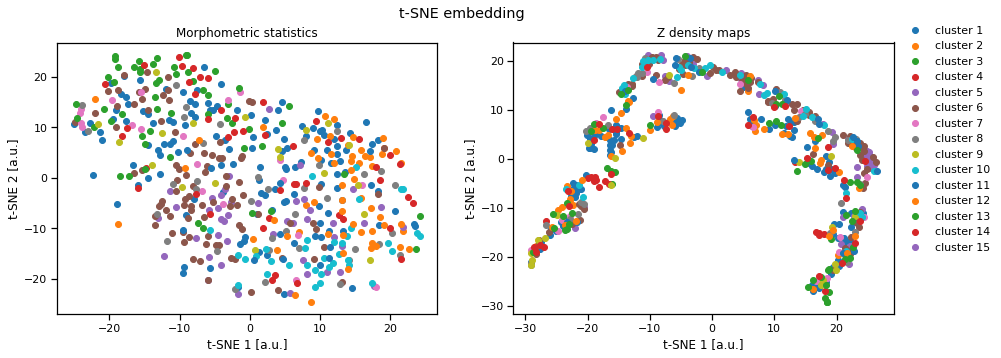

In [122]:
fig, axes = plt.subplots(1,2,figsize=(15,5))

# plot tsne fit of morpometric statistics, color-coded with cluster labels
plot_tsne(tsne_morph_stats, axes[0])
axes[0].set_xlabel('t-SNE 1 [a.u.]')
axes[0].set_ylabel('t-SNE 2 [a.u.]')

axes[0].set_title('Morphometric statistics')

# plot tsne fit of z-projected density map , color-coded with cluster labels
plot_tsne(tsne_density_maps, axes[1])
axes[1].set_xlabel('t-SNE 1 [a.u.]')
axes[1].set_ylabel('t-SNE 2 [a.u.]')
plt.legend(frameon=False, bbox_to_anchor=(1,1.1))
axes[1].set_title('Z density maps')

plt.suptitle('t-SNE embedding')

## Bonus: Hierarchical clustering

Typically, we do not have access to ground truth cell type labels but we need to infer the number of classes that are present in the data. In the following we want to explore hierarchical clustering based on morphometric statistics and on density maps. Assume that you know the number of existing cluster ($N_{clus}=14$). Visualize the clustering dendrogram (use seaborn's `clustermap` method) and then cluster the data (using agglomerative clustering and Ward's method) and assess the cluster label correspondence with ground truth labels using [two custer quality metrics](https://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation) of your choice.

*Bonus: 2.5 pts*

### Clustering on morphometric statistics

*(1pt)*

In [ ]:
true_labels = labels['cluster'].values
sns.clustermap(morphometric_data, method='ward',
               row_colors=[colors[t-1] for t in true_labels],
               cbar_pos=(1., 0.6, 0.05, 0.18), 
               xticklabels = [f.replace("_", " ").capitalize() for f in features])

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import mutual_info_score, adjusted_rand_score

agglom_morph =

print('Mutual information score:',  mutual_info_score(labels['cluster'].values, agglom_morph.labels_))
print('Adjusted rand index: ', adjusted_rand_score(labels['cluster'].values, agglom_morph.labels_))

### Clustering on density maps

*(1pt)*

In [ ]:
sns.clustermap(DM_Z, method='ward', 
               row_cluster=True, 
               row_colors=[colors[t-1] for t in true_labels], 
               cbar_pos=(1., 0.6, 0.05, 0.18), 
               xticklabels=['Bin %i'%i for i in range(1,21)])

In [ ]:
# Cluster and compare to ground truth

agglom_dm = 

print('Mutual information score:',  mutual_info_score(labels['cluster'].values, agglom_dm.labels_))
print('Adjusted rand index: ', adjusted_rand_score(labels['cluster'].values, agglom_dm.labels_))

Now plot the t-SNE embeddings from before and label each embedding with its true and, next to it, with its newly inferred cluster labels from the agglomerative clustering. 

In [ ]:
# todo plot t-sne with cluster labels of both representations

new_cluster_colors = sns.color_palette('tab20', n_colors=14)

### density maps ######

fig, axes = plt.subplots(1,2, figsize=(12,4))
axes = axes.flatten()
# plot the true cluster labels 
for k, l in enumerate(np.unique(labels['cluster'])):
    label_index = (labels['cluster'] == l).values
    axes[0].scatter(tsne_fit_dm[label_index,0], tsne_fit_dm[label_index,1], c=[colors[k]], label='Cluster %i'%l)

axes[0].set_xlabel('t-SNE 1 [a.u.]')
axes[0].set_ylabel('t-SNE 2 [a.u.]')
axes[0].set_title('True cluster')

# plot the new clustering
for k,l in enumerate(np.unique(agglom_dm.labels_)):
    label_index = agglom_dm.labels_ == l
    axes[1].scatter(tsne_fit_dm[label_index,0], tsne_fit_dm[label_index,1], c=[new_cluster_colors[k]])
axes[1].set_xlabel('t-SNE 1 [a.u.]')
axes[1].set_ylabel('t-SNE 2 [a.u.]')
axes[1].set_title('Inferred cluster')
sns.despine()
plt.suptitle('Z-density map')

### morphometrics ######

fig, axes = plt.subplots(1,2, figsize=(12,4), sharex=True)
axes = axes.flatten()

# plot the true cluster labels 
for k, l in enumerate(np.unique(labels['cluster'])):
    label_index = (labels['cluster'] == l).values
    axes[0].scatter(tsne_fit_morph[label_index,0], tsne_fit_morph[label_index,1], c=[colors[k]], label='Cluster %i'%l)

axes[0].set_xlabel('t-SNE 1 [a.u.]')
axes[0].set_ylabel('t-SNE 2 [a.u.]')
axes[0].set_title('True cluster')

# plot the new clustering
for k,l in enumerate(np.unique(agglom_morph.labels_)):
    label_index = agglom_morph.labels_ == l
    axes[1].scatter(tsne_fit_morph[label_index,0], tsne_fit_morph[label_index,1], c=[new_cluster_colors[k]])

axes[1].set_xlabel('t-SNE 1 [a.u.]')
axes[1].set_ylabel('t-SNE 2 [a.u.]')
axes[1].set_title('Inferred cluster')
sns.despine()
plt.suptitle('Morphometric statistics')

**Q:** Which representation allows for better recovery of the cell type labels? Why is that so? *(0.5 pt)*

**Answer:** 

## Extra: Predicting the projection site

Instead of its cell type, we now want to predict each cell's projection site in the thalamus which is stored in the column `labels['projection_site']`. Fit a logistic regression on both morphological representations and report its average cross validated (cv=5) prediction accuracy for each. Which representation works better to recover the prediction target? Which features are most relevant for that prediction?


You can use `LogisticRegressionCV` of the scikit-learn library directly. Since the classes are imbalanced make sure to report the balanced prediction accuracy. To understand the relevance of individual features plot the fitted linear coefficients. 

In [ ]:
from sklearn.linear_model import LogisticRegressionCV


# Fit logistic regression on density maps
lr_dm = LogisticRegressionCV(scoring='balanced_accuracy')
lr_dm.fit(DM_Z, labels['projection_site'].values)
print('Average projection site prediction accuracy on density maps: %i percent'%(lr_dm.score(DM_Z, labels['projection_site'].values)*100))


# Fit logistic regression on morphometric data
lr_morph = LogisticRegressionCV(scoring='balanced_accuracy')
lr_morph.fit(morphometric_data, labels['projection_site'].values)
print('Average projection site prediction accuracy on morphometric data: %i percent'%(lr_morph.score(morphometric_data, labels['projection_site'].values)*100))

While Z density maps allow for better recovery of cell type labels, they are worse than morphometric statistics on predicting the projection target. 

In [ ]:
lr = lr_morph

plt.plot(lr.coef_.T)
plt.gca().set_xticks(range(23))
_ = plt.gca().set_xticklabels([f.replace("_", " ").capitalize() for f in features], rotation=90)
plt.plot(range(lr.n_features_in_), [0]*lr.n_features_in_, c='grey', ls='--')
sns.despine()
plt.ylabel('Coefficient value')
plt.title('Linear weights vector')

**Q:** Which morphometrics are informative on the projection site?

**Answer:** All that are related to size. The cells projecting to Pbg tend to be bigger in dendritic diameter ($width \times depth$) and have wider branch angles. This is also in line with what Reinhard et al. find.

## Further references

Other ways to represent and compare morphologies are
* Persistence: [Description](https://link.springer.com/article/10.1007/s12021-017-9341-1) and [application on somatosensory pyramidal cell dendrites](https://academic.oup.com/cercor/article/29/4/1719/5304727) by Kanari et al. 2018

* Tree edit distance: [Heumann et al. 2009](https://link.springer.com/article/10.1007/s12021-009-9051-4)

* Sequential encoding inspired by BLAST: [Encoding](https://link.springer.com/article/10.1186/s12859-015-0604-2) and [similarity analysis on cortical dendrites](https://link.springer.com/article/10.1186/s12859-015-0605-1) by Gilette et al. 2015

* Vector point clouds: [BlastNeuron: Wan et al. 2015](https://link.springer.com/article/10.1007/s12021-015-9272-7)